#  Inert doublet model

According to this  [bug report](http://stauby.de/sarah_userforum/viewtopic.php?f=5&t=50#p252), we need to change by hand the file [prtcls1.mdl](../micromegas/SimplifiedDMIDM/work/models/prtcls1.mdl) to be sure that the DM candidate appears as the first defined $Z_2$-particle. In this case:

` etR       |~etR    |~etR    |35 ...
etI       |~etI    |~etI    |36 ...
etp       |~etp    |~Etp    |37 ...`

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import os, sys, inspect
import commands
from hep import *

Define functions to change from general basis to physical basis 

In [3]:
def run_official_idm(MHX,MH3,MHC,laL,la2,Mh,check=False):
    pd.Series({'MHX':MHX,'MH3':MH3,'MHC':MHC,'laL':laL,'la2':la2,'Mh':Mh}).to_csv('mo.dat',sep=' ')
    omegah2=-1
    if os.path.isfile('../micromegas/IDM/main'):
        mo=commands.getoutput("../micromegas/IDM/main mo.dat")
        
    return mo

def phys_to_int(mH,mA,mHc,lambda_L,v):
    '''
    See arXiv:1003.3125
    '''
    mH2=mH*mH;mA2=mA*mA;mHc2=mHc*mHc;v2=v*v
    lambda_5=(mH2-mA2)/v2
    mu2=mH2-lambda_L*v2
    lambda_3=2.*(mHc2-mu2)/v2
    lambda_4=-lambda_3-lambda_5+2*lambda_L
    return mu2,lambda_3,lambda_4,lambda_5

def int_to_phys(mu2,lambda_3,lambda_4,lambda_5,v):
    '''
    See arXiv:1003.3125
    '''
    v2=v*v
    tachyons=False
    mHc2=mu2+lambda_3*v2/2.
    if mHc2<0: tachyons=True
    mH2=mu2+(lambda_3+lambda_4+lambda_5)*v2/2.
    if mH2<0: tachyons=True
    mA2=mu2+(lambda_3+lambda_4-lambda_5)*v2/2.
    if mA2<0: tachyons=True
    if tachyons: print "Warning: Tachyionic masses"
    return np.sqrt(np.abs(np.array([mH2,mA2,mHc2]))),(lambda_3+lambda_4+lambda_5)/2 

Define function to run official micromegas IDM

In [4]:
def run_official_idm_lha(spc,check=False):
    '''
    Standard PDGs for inert scalars
    '''
    laL=(spc.blocks['MINPAR'][3]+spc.blocks['MINPAR'][4]+spc.blocks['MINPAR'][5])/2.
    MHX=spc.blocks['MASS'][35];MH3=spc.blocks['MASS'][36];MHC=spc.blocks['MASS'][37]
    la2=spc.blocks['MINPAR'][2];Mh=spc.blocks['MASS'][25]
    return run_official_idm(MHX,MH3,MHC,laL,la2,Mh,check=check)


## Check one point

###  With SARAH implementation
Based in [Scotogenic model implementation](https://github.com/restrepo/Scotogenic) by Avelino Vicente. Model files in the [SARAH/Models/SimplifiedDM/IDM](../SARAH/Models/SimplifiedDM/IDM) folder of this repo. We use below the python [hep](./hep.py) module to automalically manage input/output SARAH-Toolbox files (in a similar way to SSP)

In [5]:
a=hep(MODEL='SimplifiedDMIDM')

`a-object` is an object with many attributes and methods. Use the tab to explore them. Some of them are
* a.Series: [pandas](http://pandas.pydata.org/) Series object with the "relevant" variables 
* a.LHA: Input LesHouces file as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runSPheno() -> a.LHA_out: return LHA output files as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runmicromegas() -> a.runSPheno() -> Updated the `a-object`  with micrOMEGAS "relevant" output

Benchmark BP1 from [arXiv:1504.05949](http://arxiv.org/pdf/1504.05949v3.pdf). See also: [arXiv:1207.0084](https://arxiv.org/pdf/1207.0084v2.pdf)

In [6]:
v=a.vev
#lambda_1=0.13
ipt=pd.Series({'MHX':66,'MH3':300,'MHC':300,'lambda_L':0.0107}) #Official micromegas/IDM names
mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt.MHX,ipt.MH3,ipt.MHC,ipt.lambda_L,v)
print 'expected:',ipt.MHX,ipt.MH3,ipt.MHC
print 'obtained:',int_to_phys(mu2,lambda_3,lambda_4,lambda_5,v)[0]
devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda3Input' %lambda_3
a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda4Input' %lambda_4
a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
a.LHA.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
moc=a.runmicromegas(Direct_Detection=True)
print 'Omega h^2, SI proton, neutron =',a.Series.Omega_h2,a.Series.proton_SI,a.Series.neutron_SI
print 'mu2,lambda_3,lambda_4,lambda_5',np.sqrt(mu2),lambda_3,lambda_4,lambda_5,(lambda_3+lambda_4+lambda_5)/2.

expected: 66.0 300.0 300.0
obtained: [  66.  300.  300.]
Omega h^2, SI proton, neutron = 0.122 5.98e-10 6.137e-10
mu2,lambda_3,lambda_4,lambda_5 60.8877419158 2.84678917566 -1.41269458783 -1.41269458783 0.0107


See full `LesHouches.in.SimplifiedDMIDM` and `SPheno.spc.SimplifiedDMIDM` in __Appendix 1__

BP1 at one loop

In [7]:
v=a.vev
#lambda_1=0.13
ipt=pd.Series({'MHX':65,'MH3':306,'MHC':306,'lambda_L':0.0107}) #Official micromegas/IDM names
mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt.MHX,ipt.MH3,ipt.MHC,ipt.lambda_L,v)
print 'expected:',ipt.MHX,ipt.MH3,ipt.MHC
print 'obtained:',int_to_phys(mu2,lambda_3,lambda_4,lambda_5,v)[0]
devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
a.LHA.blocks['SPHENOINPUT'].entries[55]='1               # Calculate one loop masses'
mu2=3200.
a.LHA.blocks['MINPAR'][1]='%0.8E       #lambda3Input' %0.082
a.LHA.blocks['MINPAR'][2]='%0.8E       #lambda3Input' %0.01
a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda3Input' %lambda_3
a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda4Input' %lambda_4
a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
a.LHA.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
moc=a.runmicromegas(Direct_Detection=True)
print 'Omega h^2, SI proton, neutron =',a.Series.Omega_h2,a.Series.proton_SI,a.Series.neutron_SI
print 'mu2,lambda_3,lambda_4,lambda_5',np.sqrt(mu2),lambda_3,lambda_4,lambda_5,(lambda_3+lambda_4+lambda_5)/2.

expected: 65.0 306.0 306.0
obtained: [  65.  306.  306.]
Omega h^2, SI proton, neutron = 0.119 6.002e-10 6.16e-10
mu2,lambda_3,lambda_4,lambda_5 56.5685424949 2.97106222485 -1.47483111242 -1.47483111242 0.0107


In [8]:
a.LHA_out.blocks['MASS'].entries

_dict([(25, 125.511625),
       (35, 65.9182716),
       (36, 300.437986),
       (37, 300.6536),
       (23, 91.1887),
       (24, 80.3497269),
       (1, 0.005),
       (3, 0.095),
       (5, 4.18),
       (2, 0.0025),
       (4, 1.27),
       (6, 173.5),
       (11, 0.00051099893),
       (13, 0.105658372),
       (15, 1.77669)])

###  With the official IDM in micrOMEGAS at 
[micromegas/IDM](../micromegas/IDM)

In [9]:
omhof=run_official_idm_lha(a.LHA_out,check=True)
omo=a.micromegas_output(omhof)
print 'Omega h^2, SI proton, neutron=',omo.Omega_h2,omo.proton.SI,omo.neutron.SI
print 'micrOMEGAS-IDM/SARAH',omo.proton.SI/a.Series.proton_SI,omo.neutron.SI/a.Series.neutron_SI

Omega h^2, SI proton, neutron= 0.11271 8.885e-10 9.062e-10
micrOMEGAS-IDM/SARAH 1.4803398867 1.4711038961


See full micromegas input in __Appendix 2__

## Scan $m_{H^0}$
For the next two plots we fix:
* $m_h=126\ \text{GeV}  $
* $m_{A^0}= 701\ \text{GeV}  $
* $m_{H^+}= 701\ \text{GeV}  $
* $\lambda_L=0.1$

And vary 
* $40< m_{H^0}/\text{GeV}< 700$

In [10]:
df=pd.DataFrame()
ipt=pd.Series({'MHX':40,'MH3':701,'MHC':701,'lambda_L':0.1})
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
dm_masses=np.linspace(40,700,100)
for MHX in dm_masses:
    if np.where(dm_masses==MHX)[0][0]%10==0: #find the index of the array entry
        print np.where(dm_masses==MHX)[0][0]
    ipt.MHX=MHX
    mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt.MHX,ipt.MH3,ipt.MHC,ipt.lambda_L,a.vev)
    a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
    a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda4Input' %lambda_3
    a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda3Input' %lambda_4
    a.LHA.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
    a.runmicromegas(Direct_Detection=True)
    a.Series=a.Series.append(ipt)
    a.Series=a.Series.append(pd.Series({'MH0':a.LHA_out.blocks['MASS'][35],\
                                        'MA0':a.LHA_out.blocks['MASS'][36],\
                                        'MHc':a.LHA_out.blocks['MASS'][37]}))
    omhof=run_official_idm_lha(a.LHA_out,check=True)
    omo=a.micromegas_output(omhof)
    a.Series['Omega_h2_official']=omo.Omega_h2
    a.Series['proton_SI_official']=omo.proton.SI
    a.Series['neutron_SI_official']=omo.neutron.SI
    df=df.append(a.Series,ignore_index=True)

0
10
20
30
40
50
60
70
80
90


### Relic density

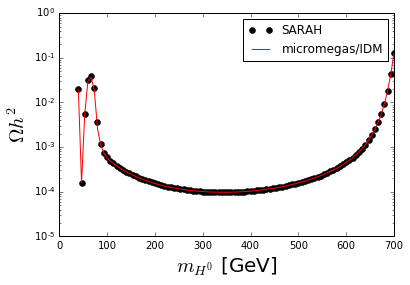

In [11]:
dfm=df[df.MH0<df.MHc]
plt.semilogy(dfm.MH0,dfm.Omega_h2,'ko',label='SARAH')
plt.semilogy(dfm.MH0,dfm.Omega_h2_official,'r-',label='micromegas/IDM')
plt.xlabel(r'$m_{H^0}$ [GeV]',size=20)
plt.ylabel(r'$\Omega h^2$',size=20)
plt.legend(loc='best')
plt.savefig('omega.pdf')

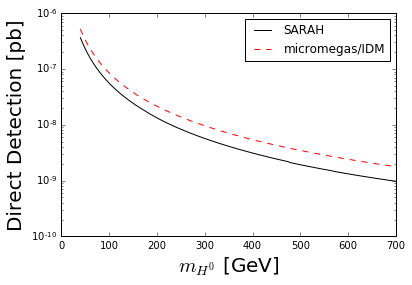

In [12]:
dfm=df[df.MH0<df.MHc]
plt.semilogy(dfm.MH0,dfm.proton_SI,'k-',label='SARAH')
plt.semilogy(dfm.MH0,dfm.proton_SI_official,'r--',label='micromegas/IDM')
plt.xlabel(r'$m_{H^0}$ [GeV]',size=20)
plt.ylabel(r'Direct Detection [pb]' ,size=20)
plt.legend(loc='best')
plt.savefig('dd.pdf')

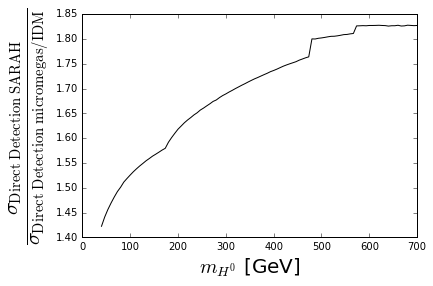

In [17]:
plt.plot(dfm.MH0,dfm.proton_SI_official/dfm.proton_SI,'k-')
plt.xlabel(r'$m_{H^0}$ [GeV]',size=20)
plt.ylabel(r'$\frac{\sigma_{\rm Direct\ Detection\ SARAH}}{\sigma_{\rm Direct\ Detection\ micromegas/IDM}}$' ,size=30)

### Conclusion
The relic density is OK but the direct detection is a factor around 1.5 larger

## Bug in SARAH: Now fixed!
After the ma

The big problem appears for a degenate spectrum. For the next two plots we fix 
* $m_h=126\ \text{GeV} $
* $\lambda_L=0.1$

And vary $m_{\text{DM}}= m_{H^0}=m_{A^0}=m_{A^0}$
* $90< m_{\text{DM}}/\text{GeV}< 700$

After fix by hand [prtcls1.mdl](../micromegas/SimplifiedDMIDM/work/models/prtcls1.mdl), the problem disappear

In [15]:
dfd=pd.DataFrame()
ipt=pd.Series({'MHX':40,'MH3':120,'MHC':120,'lambda_L':0.1})
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
dm_masses=np.linspace(90,700,100)
for MHX in dm_masses:
    if np.where(dm_masses==MHX)[0][0]%10==0: #find the index of the array entry
        print np.where(dm_masses==MHX)[0][0]
    ipt.MHX=MHX
    ipt.MH3=MHX
    ipt.MHC=MHX
    mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt.MHX,ipt.MH3,ipt.MHC,ipt.lambda_L,a.vev)
    a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
    a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda4Input' %lambda_3
    a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda3Input' %lambda_4
    a.LHA.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
    a.runmicromegas(Direct_Detection=True)
    a.Series=a.Series.append(ipt)
    a.Series=a.Series.append(pd.Series({'MH0':a.LHA_out.blocks['MASS'][35],\
                                        'MA0':a.LHA_out.blocks['MASS'][36],\
                                        'MHc':a.LHA_out.blocks['MASS'][37]}))
    omhof=run_official_idm_lha(a.LHA_out,check=True)
    omo=a.micromegas_output(omhof)
    a.Series['Omega_h2_official']=omo.Omega_h2
    a.Series['proton_SI_official']=omo.proton.SI
    a.Series['neutron_SI_official']=omo.neutron.SI
    dfd=dfd.append(a.Series,ignore_index=True)

0
10
20
30
40
50
60
70
80
90


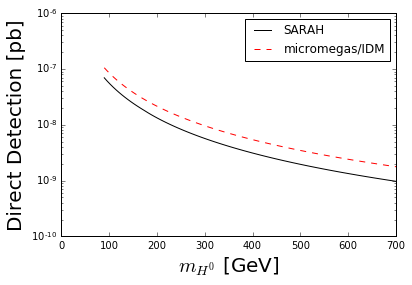

In [16]:
plt.semilogy(dfd.MH0,dfd.proton_SI,'k-',label='SARAH')
plt.semilogy(dfd.MH0,dfd.proton_SI_official,'r--',label='micromegas/IDM')
plt.xlabel(r'$m_{H^0}$ [GeV]',size=20)
plt.ylabel(r'Direct Detection [pb]' ,size=20)
plt.legend(loc='best')
plt.savefig('ddd.pdf')

### Conclusion
In [prtcls1.mdl](../micromegas/SimplifiedDMIDM/work/models/prtcls1.mdl) the order of the particles may be important

## Wrong benchmark
We now will produce specific input/output files for the bug report
### SARAH

In [18]:
v=a.vev
#lambda_1=0.13
ipt=pd.Series({'MHX':600,'MH3':600,'MHC':600,'lambda_L':0.1}) #Official IDM micromegas names
mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt.MHX,ipt.MH3,ipt.MHC,ipt.lambda_L,v)
print 'expected:',ipt.MHX,ipt.MH3,ipt.MHC
print 'obtained:',int_to_phys(mu2,lambda_3,lambda_4,lambda_5,v)
devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda3Input' %lambda_3
a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda4Input' %lambda_4
a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
a.LHA.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
moc=a.runmicromegas(Direct_Detection=True)
print 'Omega_h2,DD =',a.Series.Omega_h2,a.Series.proton_SI,a.Series.neutron_SI

expected: 600.0 600.0 600.0
obtained: (array([ 600.,  600.,  600.]), 0.10000000000000001)
Omega_h2,DD = 0.109 1.338e-09 1.378e-09


* Input File: [LesHouches.in.SimplifiedDMIDM](./LesHouches.in.SimplifiedDMIDM)
* Output File: [SPheno.spc.SimplifiedDMIDM](./SPheno.spc.SimplifiedDMIDM)

In [ ]:
%%bash
#../micromegas/SimplifiedDMIDM/CalcOmega_with_DDetection_MOv4.2 SPheno.spc.SimplifiedDMIDM

### micromegas/IDM

In [19]:
omhof=run_official_idm_lha(a.LHA_out,check=True)
omo=a.micromegas_output(omhof)
print 'Omega h^2, SI proton, neutron=',omo.Omega_h2,omo.proton.SI,omo.neutron.SI

Omega h^2, SI proton, neutron= 0.10983 2.412e-09 2.46e-09


In [ ]:
%%bash
#../micromegas/IDM/main mo.dat

Input file: [mo.dat](./mo.dat)


##  Appendix 1
Full input/output for check point with
* $m_h=126 $GeV
* $m_[H^0]= 65\ \text{GeV}$
* $m_[A^0]= 701\ \text{GeV}  $
* $m_[H^+]= 701\ \text{GeV}  $
* $\lambda_L=0.01$

In [20]:
cat LesHouches.in.SimplifiedDMIDM

BLOCK MODSEL
   1   1              #  1/0: High/low scale input 
   2   1              # Boundary Condition  
   6   1              # Generation Mixing 

BLOCK SMINPUTS
   2   1.166370E-05   # G_F,Fermi constant 
   3   1.187000E-01   # alpha_s(MZ) SM MSbar 
   4   9.118870E+01   # Z-boson pole mass 
   5   4.180000E+00   # m_b(mb) SM MSbar 
   6   1.735000E+02   # m_top(pole) 
   7   1.776690E+00   # m_tau(pole) 

BLOCK MINPAR
   1   8.20000000E-02       #lambda3Input
   2   1.00000000E-02       #lambda3Input
   3   2.00000000E-01       #lambda3Input
   4   -5.27355937E-16       #lambda4Input
   5   0.00000000E+00       #lambda5Input
   6   3.53937543E+05       #mEt2Input

BLOCK SPHENOINPUT
   1   -1             # error level 
   2   0              # SPA conventions 
   11   1              # calculate branching ratios 
   13   1               # 3-Body decays: none (0), fermion (1), scalar (2), both (3)
   14   0              # Run couplings to scale of decaying particle 
   12   1.000

In [21]:
cat SPheno.spc.SimplifiedDMIDM

# SUSY Les Houches Accord 2 - SimplifiedDM/IDM Spectrum + Decays + Flavor Observables
# SPheno module generated by SARAH
# ----------------------------------------------------------------------
# SPheno v3.3.8  
#   W. Porod, Comput. Phys. Commun. 153 (2003) 275-315, hep-ph/0301101
#   W. Porod, F.Staub, Comput.Phys.Commun.183 (2012) 2458-2469, arXiv:1104.1573
# SARAH: 4.8.5   
#   F. Staub; arXiv:0806.0538 (online manual)
#   F. Staub; Comput. Phys. Commun. 181 (2010) 1077-1086; arXiv:0909.2863
#   F. Staub; Comput. Phys. Commun. 182 (2011)  808-833; arXiv:1002.0840
#   F. Staub; Comput. Phys. Commun. 184 (2013)  1792-1809; arXiv:1207.0906
#   F. Staub; Comput. Phys. Commun. 185 (2014)  1773-1790; arXiv:1309.7223 
# Including the calculation of flavor observables based on the FlavorKit 
#   W. Porod, F. Staub, A. Vicente; Eur.Phys.J. C74 (2014) 8, 2992; arXiv:1405.1434 
# Two-loop masss corrections to Higgs fields based on 
#   M. D. Goodsell, K. Nickel, F. Staub; arXiv:1411.0675 
#  

## Appendix 2
Input file for official IDM in micromegas

In [22]:
cat mo.dat

MH3 600.0
MHC 600.0
MHX 600.0
Mh 99.7117308
la2 0.01
laL 0.1


[Jupyter home](./draft.pdf)

See [Output LaTeX](./draft.tex) file

In [ ]:
%%bash
pdflatex draft.tex > /dev/null

[[PDF]](./draft.pdf)